# Data Exploration & Metrics - NYC Mobility & Weather Analytics

Comprehensive data exploration analyzing 12.4M+ trips across Yellow Taxi, FHV (Uber/Lyft), and CitiBike.

**Analysis Sections:**
1. Temporal Patterns - Hourly, daily, and weekly trends
2. Weather Impact - How weather affects trip volume and patterns
3. Mode Share Analysis - Comparison across transportation modes
4. Geographic Patterns - Top pickup/dropoff locations
5. Comparative Analysis - Weekend vs. weekday, weather conditions
6. Key Findings & Insights

## Setup

In [1]:
import duckdb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import numpy as np

# Configure plotting
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Connect to database
PROJECT_ROOT = Path.cwd().parent
DB_PATH = PROJECT_ROOT / 'data' / 'nyc_mobility.duckdb'
conn = duckdb.connect(str(DB_PATH), read_only=True)

print(f'✅ Connected to DuckDB: {DB_PATH}')
print(f'📊 Database size: {DB_PATH.stat().st_size / (1024**3):.2f} GB')

✅ Connected to DuckDB: /Users/brandoncgay/Documents/Projects/nyc-mobility-weather-analytics/data/nyc_mobility.duckdb
📊 Database size: 2.76 GB


## 1. Temporal Patterns

Analyze how trip volume varies by time of day, day of week, and over the date range.

### 1.1 Hourly Patterns by Mode

In [2]:
# Hourly trip counts by transportation mode
hourly = conn.execute("""
    SELECT 
        t.hour,
        ft.trip_type,
        COUNT(*) as trips,
        AVG(ft.trip_duration_minutes) as avg_duration
    FROM core_core.fct_trips ft
    JOIN core_core.dim_time t ON ft.time_key = t.time_key
    GROUP BY t.hour, ft.trip_type
    ORDER BY t.hour, ft.trip_type
""").fetchdf()

print(f"Total records: {len(hourly)}")
display(hourly.head(10))

Total records: 72


,hour,trip_type,trips,avg_duration
0,0,citibike,59633,10.691832
1,0,fhv,255586,38.296198
2,0,yellow_taxi,379911,19.013393
3,1,citibike,93833,11.060085
4,1,fhv,331870,39.811074
5,1,yellow_taxi,495002,18.583066
6,2,citibike,78023,11.389424
7,2,fhv,363570,40.551099
8,2,yellow_taxi,526786,18.380707
9,3,citibike,65015,12.037776


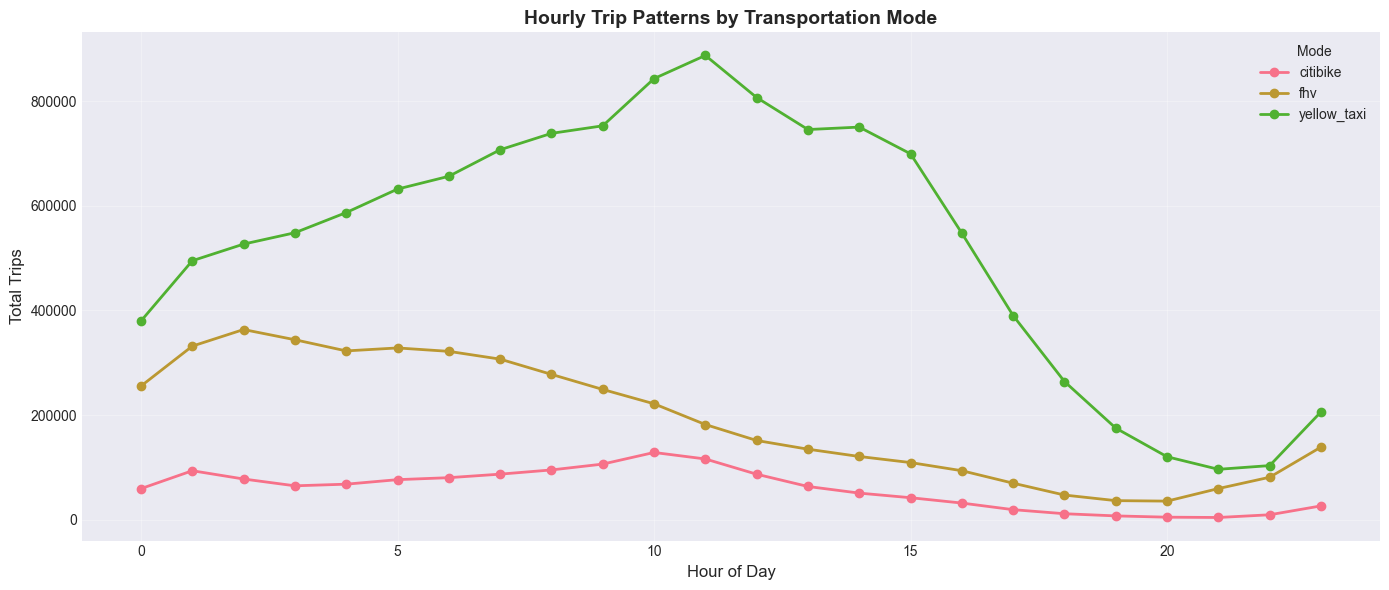


📈 Peak hours by mode:
  citibike: Hour 10 with 128,704 trips
  fhv: Hour 2 with 363,570 trips
  yellow_taxi: Hour 11 with 887,200 trips


In [3]:
# Visualize hourly patterns
fig, ax = plt.subplots(figsize=(14, 6))

for trip_type in hourly['trip_type'].unique():
    data = hourly[hourly['trip_type'] == trip_type]
    ax.plot(data['hour'], data['trips'], marker='o', linewidth=2, label=trip_type)

ax.set_xlabel('Hour of Day', fontsize=12)
ax.set_ylabel('Total Trips', fontsize=12)
ax.set_title('Hourly Trip Patterns by Transportation Mode', fontsize=14, fontweight='bold')
ax.legend(title='Mode', fontsize=10)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n📈 Peak hours by mode:")
for trip_type in hourly['trip_type'].unique():
    peak = hourly[hourly['trip_type'] == trip_type].nlargest(1, 'trips')
    print(f"  {trip_type}: Hour {peak['hour'].values[0]} with {peak['trips'].values[0]:,} trips")

### 1.2 Daily Trends

In [4]:
# Daily trip trends
daily = conn.execute("""
    SELECT 
        d.date,
        d.is_weekend,
        ft.trip_type,
        COUNT(*) as trips,
        SUM(CASE WHEN ft.is_rush_hour THEN 1 ELSE 0 END) as rush_hour_trips
    FROM core_core.fct_trips ft
    JOIN core_core.dim_date d ON ft.date_key = d.date_key
    GROUP BY d.date, d.is_weekend, ft.trip_type
    ORDER BY d.date
""").fetchdf()

print(f"Date range: {daily['date'].min()} to {daily['date'].max()}")
print(f"Total days: {daily['date'].nunique()}")
display(daily.head(10))

Date range: 2025-08-31 00:00:00 to 2025-11-30 00:00:00
Total days: 92


,date,is_weekend,trip_type,trips,rush_hour_trips
0,2025-08-31,True,yellow_taxi,13711,9142.0
1,2025-08-31,True,fhv,7434,3289.0
2,2025-09-01,False,yellow_taxi,90648,22679.0
3,2025-09-01,False,fhv,41412,9044.0
4,2025-09-02,False,fhv,76578,16515.0
5,2025-09-02,False,yellow_taxi,115784,25003.0
6,2025-09-03,False,yellow_taxi,130579,27458.0
7,2025-09-03,False,fhv,83813,17542.0
8,2025-09-04,False,yellow_taxi,154806,35457.0
9,2025-09-04,False,fhv,83615,18131.0


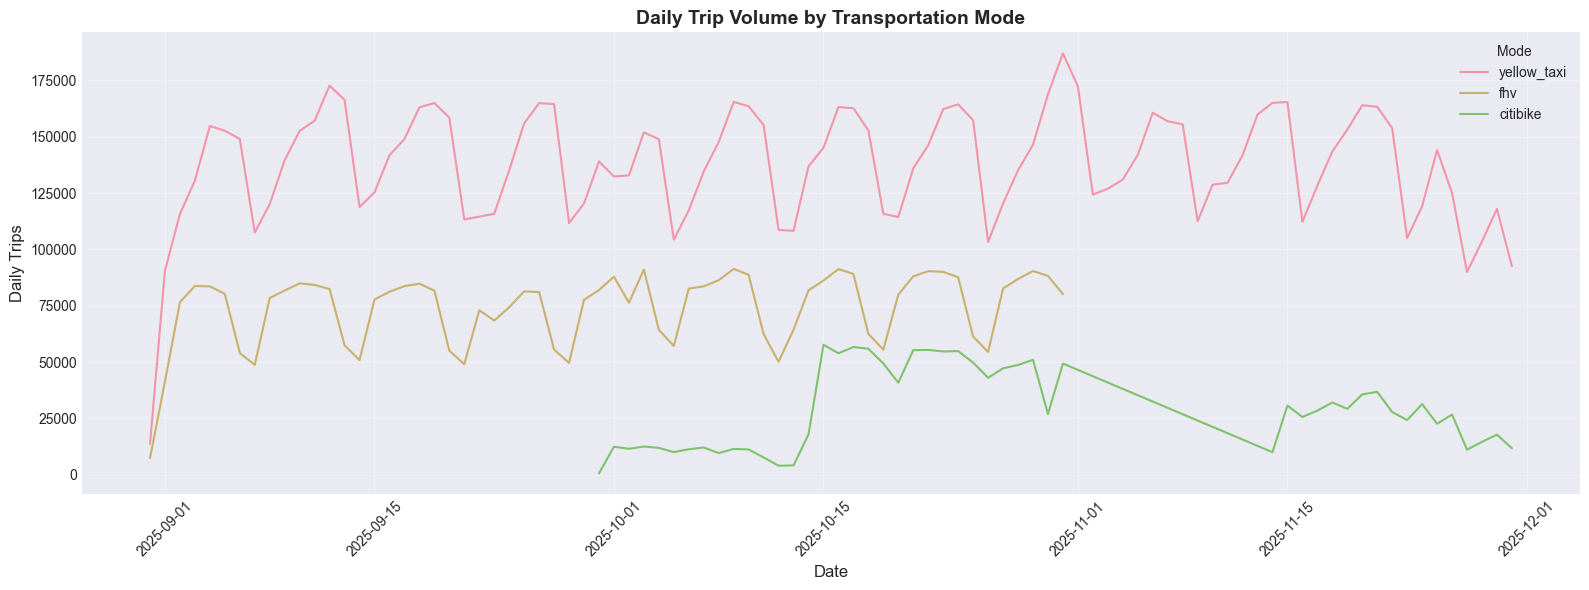


📊 Average daily trips by mode:
  citibike: 28,919 trips/day
  fhv: 73,983 trips/day
  yellow_taxi: 137,605 trips/day


In [5]:
# Visualize daily trends
fig, ax = plt.subplots(figsize=(16, 6))

for trip_type in daily['trip_type'].unique():
    data = daily[daily['trip_type'] == trip_type]
    ax.plot(data['date'], data['trips'], linewidth=1.5, alpha=0.7, label=trip_type)

ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Daily Trips', fontsize=12)
ax.set_title('Daily Trip Volume by Transportation Mode', fontsize=14, fontweight='bold')
ax.legend(title='Mode', fontsize=10)
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("\n📊 Average daily trips by mode:")
avg_daily = daily.groupby('trip_type')['trips'].mean()
for mode, avg in avg_daily.items():
    print(f"  {mode}: {avg:,.0f} trips/day")

### 1.3 Day of Week Patterns

In [6]:
# Day of week analysis
dow = conn.execute("""
    SELECT 
        d.day_name,
        d.day_of_week,
        ft.trip_type,
        COUNT(*) as trips,
        AVG(ft.trip_distance) as avg_distance
    FROM core_core.fct_trips ft
    JOIN core_core.dim_date d ON ft.date_key = d.date_key
    GROUP BY d.day_name, d.day_of_week, ft.trip_type
    ORDER BY d.day_of_week, ft.trip_type
""").fetchdf()

display(dow)

,day_name,day_of_week,trip_type,trips,avg_distance
0,Sunday,0,citibike,168289,NaN
1,Sunday,0,fhv,423262,NaN
2,Sunday,0,yellow_taxi,1444125,7.989035
3,Monday,1,citibike,163494,NaN
4,Monday,1,fhv,658172,NaN
5,Monday,1,yellow_taxi,1534752,7.223480
6,Tuesday,2,citibike,189445,NaN
7,Tuesday,2,fhv,730490,NaN
8,Tuesday,2,yellow_taxi,1743110,5.519211
9,Wednesday,3,citibike,242265,NaN


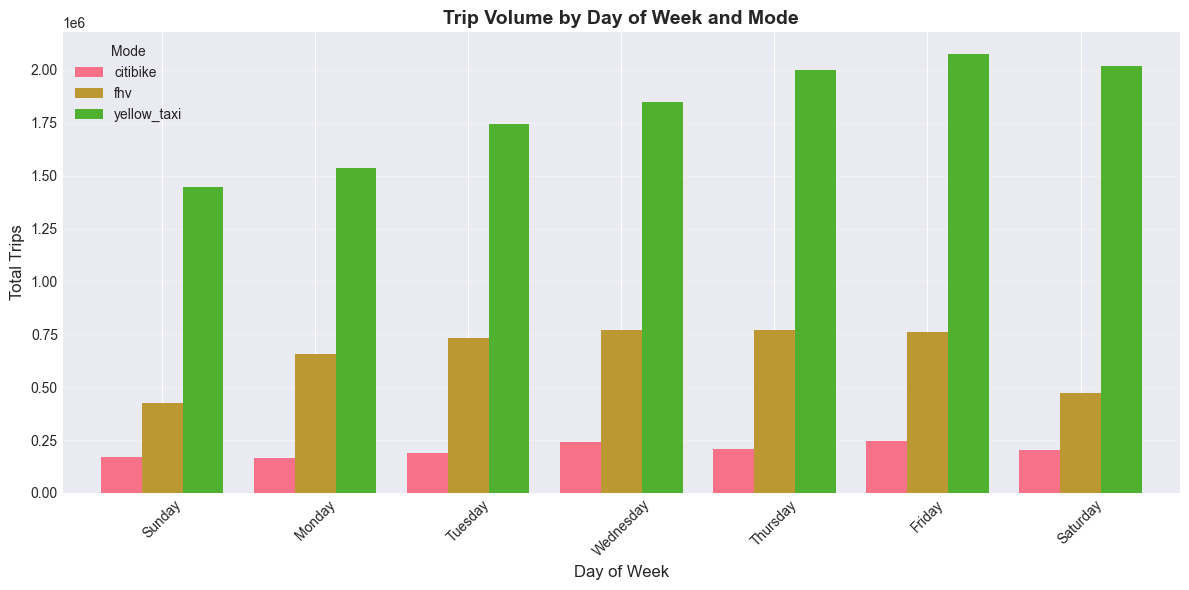


📅 Weekend vs Weekday:
  citibike: -11.6% on weekends
  fhv: -39.3% on weekends
  yellow_taxi: -5.9% on weekends


In [7]:
# Visualize day of week patterns
fig, ax = plt.subplots(figsize=(12, 6))

dow_pivot = dow.pivot(index='day_name', columns='trip_type', values='trips')
day_order = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
dow_pivot = dow_pivot.reindex(day_order)

dow_pivot.plot(kind='bar', ax=ax, width=0.8)
ax.set_xlabel('Day of Week', fontsize=12)
ax.set_ylabel('Total Trips', fontsize=12)
ax.set_title('Trip Volume by Day of Week and Mode', fontsize=14, fontweight='bold')
ax.legend(title='Mode', fontsize=10)
ax.grid(True, alpha=0.3, axis='y')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("\n📅 Weekend vs Weekday:")
for trip_type in dow['trip_type'].unique():
    data = dow[dow['trip_type'] == trip_type]
    weekday_avg = data[data['day_of_week'].between(1, 5)]['trips'].mean()
    weekend_avg = data[data['day_of_week'].isin([0, 6])]['trips'].mean()
    pct_diff = ((weekend_avg - weekday_avg) / weekday_avg) * 100
    print(f"  {trip_type}: {pct_diff:+.1f}% on weekends")

## 2. Weather Impact Analysis

Explore how weather conditions affect trip volume and patterns.

### 2.1 Temperature Impact

In [8]:
# Temperature vs trip volume
temp_impact = conn.execute("""
    SELECT 
        ft.temp_category,
        ft.trip_type,
        COUNT(*) as trips,
        AVG(ft.trip_distance) as avg_distance,
        AVG(ft.trip_duration_minutes) as avg_duration
    FROM core_core.fct_trips ft
    WHERE ft.temp_category IS NOT NULL
    GROUP BY ft.temp_category, ft.trip_type
    ORDER BY 
        CASE ft.temp_category
            WHEN 'cold' THEN 1
            WHEN 'cool' THEN 2
            WHEN 'mild' THEN 3
            WHEN 'warm' THEN 4
            WHEN 'hot' THEN 5
        END,
        ft.trip_type
""").fetchdf()

display(temp_impact)

,temp_category,trip_type,trips,avg_distance,avg_duration
0,cold,citibike,3278,NaN,10.125076
1,cold,yellow_taxi,31704,7.284896,17.037850
2,cool,citibike,468836,NaN,10.950925
3,cool,fhv,311620,NaN,24.930457
4,cool,yellow_taxi,3250757,7.273562,17.979999
5,mild,citibike,878435,NaN,12.969257
6,mild,fhv,1835823,NaN,26.351909
7,mild,yellow_taxi,4679307,6.255814,18.893030
8,warm,citibike,66460,NaN,13.830921
9,warm,fhv,294650,NaN,26.283971


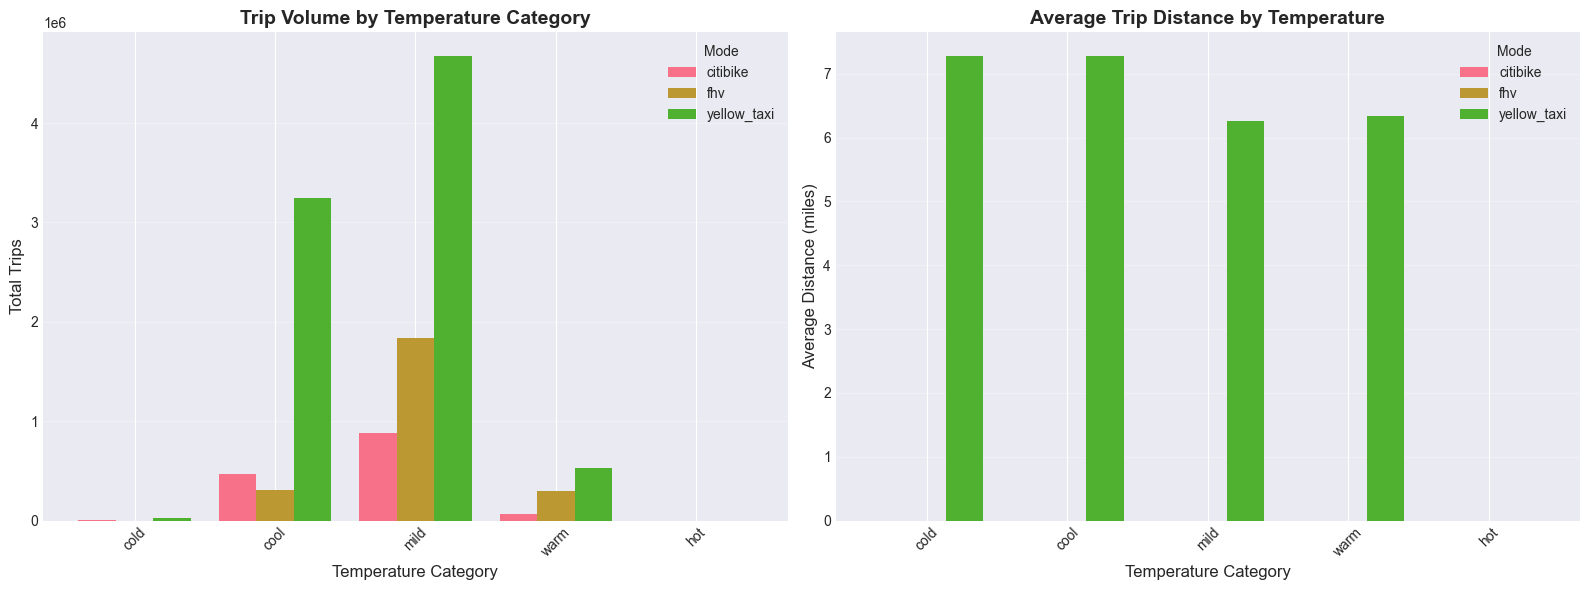

In [9]:
# Visualize temperature impact
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Trip counts by temperature
temp_pivot = temp_impact.pivot(index='temp_category', columns='trip_type', values='trips')
temp_order = ['cold', 'cool', 'mild', 'warm', 'hot']
temp_pivot = temp_pivot.reindex(temp_order)

temp_pivot.plot(kind='bar', ax=ax1, width=0.8)
ax1.set_xlabel('Temperature Category', fontsize=12)
ax1.set_ylabel('Total Trips', fontsize=12)
ax1.set_title('Trip Volume by Temperature Category', fontsize=14, fontweight='bold')
ax1.legend(title='Mode', fontsize=10)
ax1.grid(True, alpha=0.3, axis='y')
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)

# Average distance by temperature
temp_dist_pivot = temp_impact.pivot(index='temp_category', columns='trip_type', values='avg_distance')
temp_dist_pivot = temp_dist_pivot.reindex(temp_order)

temp_dist_pivot.plot(kind='bar', ax=ax2, width=0.8)
ax2.set_xlabel('Temperature Category', fontsize=12)
ax2.set_ylabel('Average Distance (miles)', fontsize=12)
ax2.set_title('Average Trip Distance by Temperature', fontsize=14, fontweight='bold')
ax2.legend(title='Mode', fontsize=10)
ax2.grid(True, alpha=0.3, axis='y')
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)

plt.tight_layout()
plt.show()

### 2.2 Precipitation Impact

In [10]:
# Precipitation vs trip volume
precip_impact = conn.execute("""
    SELECT 
        ft.precipitation_type,
        ft.trip_type,
        COUNT(*) as trips,
        AVG(ft.trip_duration_minutes) as avg_duration,
        AVG(ft.trip_distance) as avg_distance
    FROM core_core.fct_trips ft
    WHERE ft.precipitation_type IS NOT NULL
    GROUP BY ft.precipitation_type, ft.trip_type
    ORDER BY 
        CASE ft.precipitation_type
            WHEN 'none' THEN 1
            WHEN 'rain' THEN 2
            WHEN 'snow' THEN 3
            WHEN 'mixed' THEN 4
        END,
        ft.trip_type
""").fetchdf()

display(precip_impact)

,precipitation_type,trip_type,trips,avg_duration,avg_distance
0,none,citibike,1329084,12.394298,NaN
1,none,fhv,2161051,26.242766,NaN
2,none,yellow_taxi,7612806,18.500311,6.622818
3,rain,citibike,86468,11.499480,NaN
4,rain,fhv,281042,25.543819,NaN
5,rain,yellow_taxi,837821,18.717628,6.894034
6,snow,yellow_taxi,26698,21.330062,9.162203
7,mixed,citibike,1457,8.119423,NaN
8,mixed,yellow_taxi,9906,21.572380,3.786088


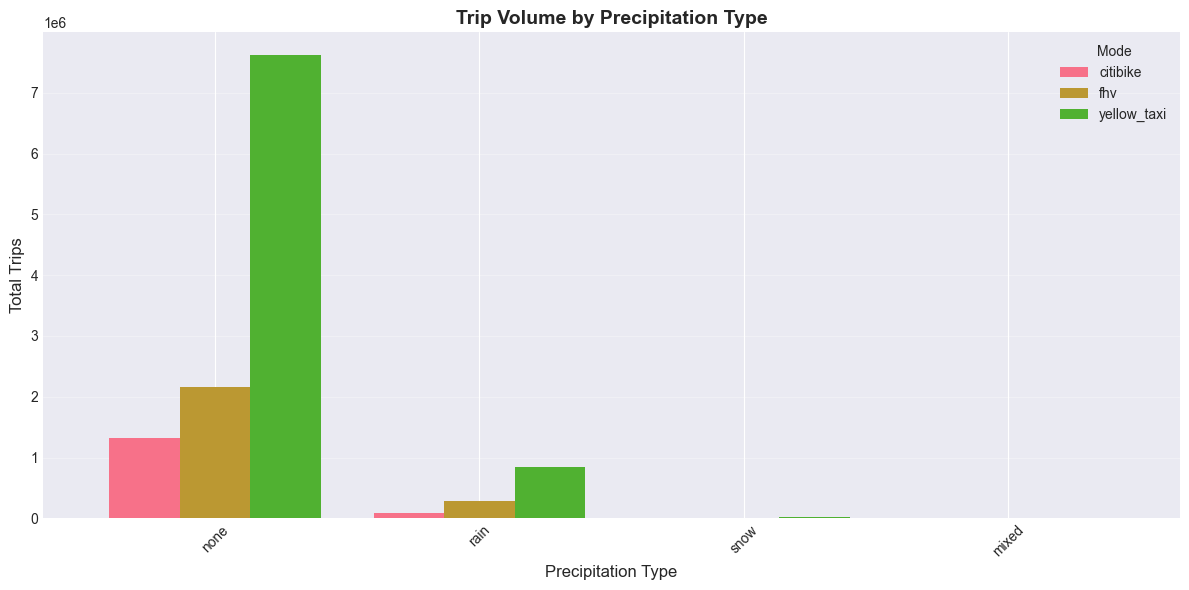


🌧️ Impact of rain on trip volume:
  citibike: -93.5% change in rain
  fhv: -87.0% change in rain
  yellow_taxi: -89.0% change in rain


In [11]:
# Visualize precipitation impact
fig, ax = plt.subplots(figsize=(12, 6))

precip_pivot = precip_impact.pivot(index='precipitation_type', columns='trip_type', values='trips')
precip_order = ['none', 'rain', 'snow', 'mixed']
precip_pivot = precip_pivot.reindex(precip_order)

precip_pivot.plot(kind='bar', ax=ax, width=0.8)
ax.set_xlabel('Precipitation Type', fontsize=12)
ax.set_ylabel('Total Trips', fontsize=12)
ax.set_title('Trip Volume by Precipitation Type', fontsize=14, fontweight='bold')
ax.legend(title='Mode', fontsize=10)
ax.grid(True, alpha=0.3, axis='y')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("\n🌧️ Impact of rain on trip volume:")
for trip_type in precip_impact['trip_type'].unique():
    data = precip_impact[precip_impact['trip_type'] == trip_type]
    none = data[data['precipitation_type'] == 'none']['trips'].sum()
    rain = data[data['precipitation_type'] == 'rain']['trips'].sum()
    pct_change = ((rain - none) / none) * 100
    print(f"  {trip_type}: {pct_change:+.1f}% change in rain")

### 2.3 Weather Correlation Analysis

Sample size: 1463 unique weather conditions


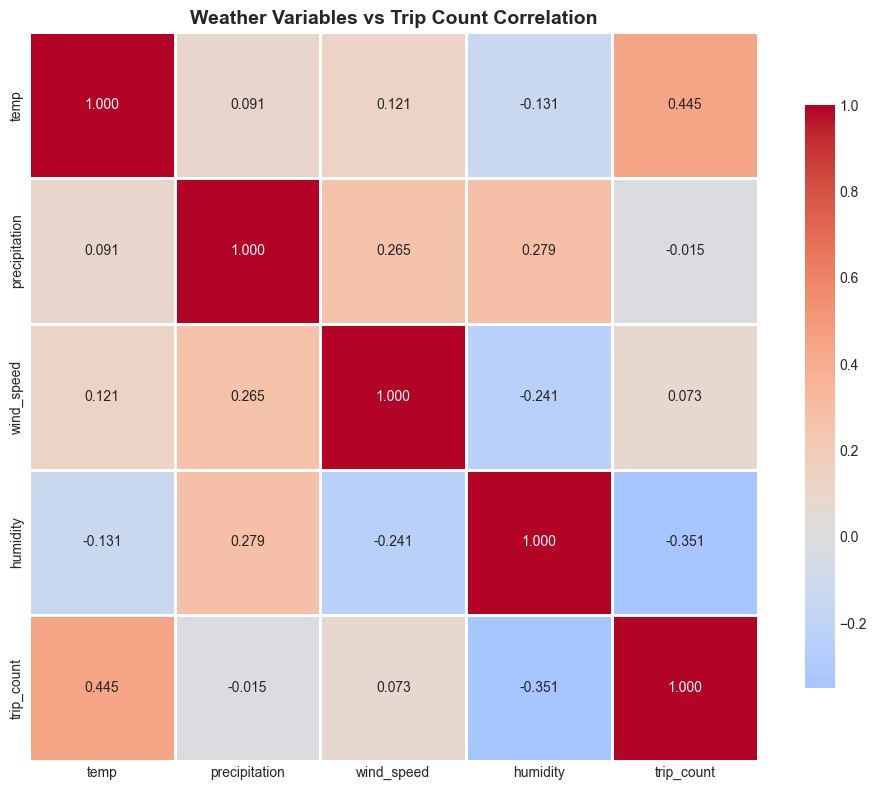


🔗 Correlations with trip count:
trip_count       1.000000
temp             0.445154
wind_speed       0.072508
precipitation   -0.015088
humidity        -0.350725
Name: trip_count, dtype: float64


In [12]:
# Get hourly aggregates with weather data (denormalized on fct_trips)
weather_corr = conn.execute("""
    SELECT 
        temperature_celsius as temp,
        precipitation,
        wind_speed,
        humidity,
        COUNT(*) as trip_count
    FROM core_core.fct_trips
    WHERE temperature_celsius IS NOT NULL
    GROUP BY temperature_celsius, precipitation, wind_speed, humidity
""").fetchdf()

print(f"Sample size: {len(weather_corr)} unique weather conditions")

# Calculate correlation matrix
corr_matrix = weather_corr[['temp', 'precipitation', 'wind_speed', 'humidity', 'trip_count']].corr()

# Visualize correlation heatmap
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8}, ax=ax)
ax.set_title('Weather Variables vs Trip Count Correlation', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n🔗 Correlations with trip count:")
print(corr_matrix['trip_count'].sort_values(ascending=False))

## 3. Mode Share Analysis

Compare transportation mode usage patterns.

In [13]:
# Overall mode share
mode_share = conn.execute("""
    SELECT 
        trip_type,
        COUNT(*) as trips,
        ROUND(COUNT(*) * 100.0 / SUM(COUNT(*)) OVER (), 2) as pct_share,
        AVG(trip_distance) as avg_distance,
        AVG(trip_duration_minutes) as avg_duration
    FROM core_core.fct_trips
    GROUP BY trip_type
    ORDER BY trips DESC
""").fetchdf()

display(mode_share)

,trip_type,trips,pct_share,avg_distance,avg_duration
0,yellow_taxi,12659674,67.83,6.732906,18.563698
1,fhv,4586963,24.58,NaN,34.251165
2,citibike,1417052,7.59,NaN,12.338151


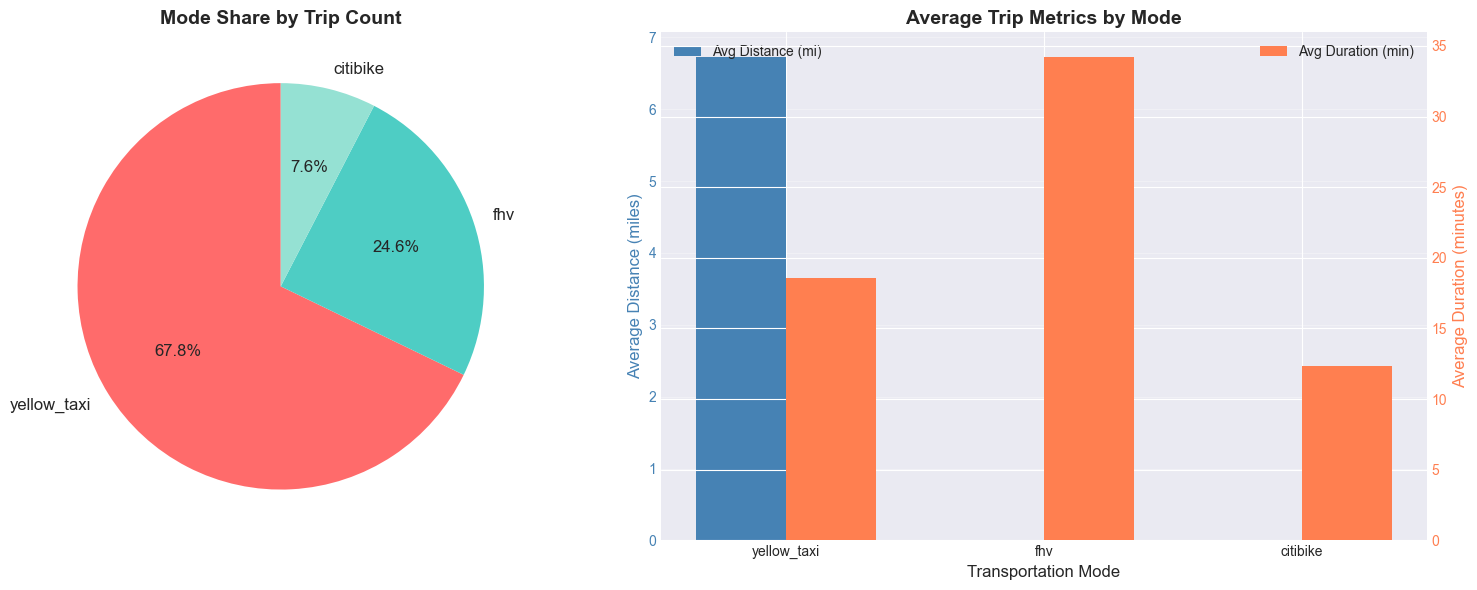

In [14]:
# Visualize mode share
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Pie chart
colors = ['#FF6B6B', '#4ECDC4', '#95E1D3']
ax1.pie(mode_share['trips'], labels=mode_share['trip_type'], autopct='%1.1f%%',
        startangle=90, colors=colors, textprops={'fontsize': 12})
ax1.set_title('Mode Share by Trip Count', fontsize=14, fontweight='bold')

# Bar chart comparing metrics
x = np.arange(len(mode_share))
width = 0.35

ax2_twin = ax2.twinx()
bars1 = ax2.bar(x - width/2, mode_share['avg_distance'], width, label='Avg Distance (mi)', color='steelblue')
bars2 = ax2_twin.bar(x + width/2, mode_share['avg_duration'], width, label='Avg Duration (min)', color='coral')

ax2.set_xlabel('Transportation Mode', fontsize=12)
ax2.set_ylabel('Average Distance (miles)', fontsize=12, color='steelblue')
ax2_twin.set_ylabel('Average Duration (minutes)', fontsize=12, color='coral')
ax2.set_title('Average Trip Metrics by Mode', fontsize=14, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(mode_share['trip_type'])
ax2.tick_params(axis='y', labelcolor='steelblue')
ax2_twin.tick_params(axis='y', labelcolor='coral')
ax2.legend(loc='upper left')
ax2_twin.legend(loc='upper right')
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 4. Geographic Patterns

Identify top pickup and dropoff locations.

In [15]:
# Top pickup locations
top_pickup = conn.execute("""
    SELECT 
        dl.zone_name,
        dl.borough,
        ft.trip_type,
        COUNT(*) as pickups
    FROM core_core.fct_trips ft
    JOIN core_core.dim_location dl ON ft.pickup_location_key = dl.location_key
    WHERE ft.trip_type IN ('yellow_taxi', 'fhv')  -- CitiBike has different location schema
    GROUP BY dl.zone_name, dl.borough, ft.trip_type
    ORDER BY pickups DESC
    LIMIT 20
""").fetchdf()

print("🚕 Top 20 Pickup Locations:")
display(top_pickup)

🚕 Top 20 Pickup Locations:


,zone_name,borough,trip_type,pickups
0,West Village,Manhattan,yellow_taxi,581220
1,Norwood,Bronx,yellow_taxi,535384
2,Little Italy/NoLiTa,Brooklyn,yellow_taxi,513464
3,West Farms/Bronx River,Bronx,yellow_taxi,507759
4,Riverdale/North Riverdale/Fieldston,Bronx,yellow_taxi,396213
5,Oakland Gardens,Queens,yellow_taxi,389155
6,Washington Heights South,Manhattan,yellow_taxi,371727
7,Marine Park/Mill Basin,Brooklyn,yellow_taxi,364969
8,West Chelsea/Hudson Yards,Manhattan,yellow_taxi,333855
9,Manhattan Valley,Manhattan,yellow_taxi,332520


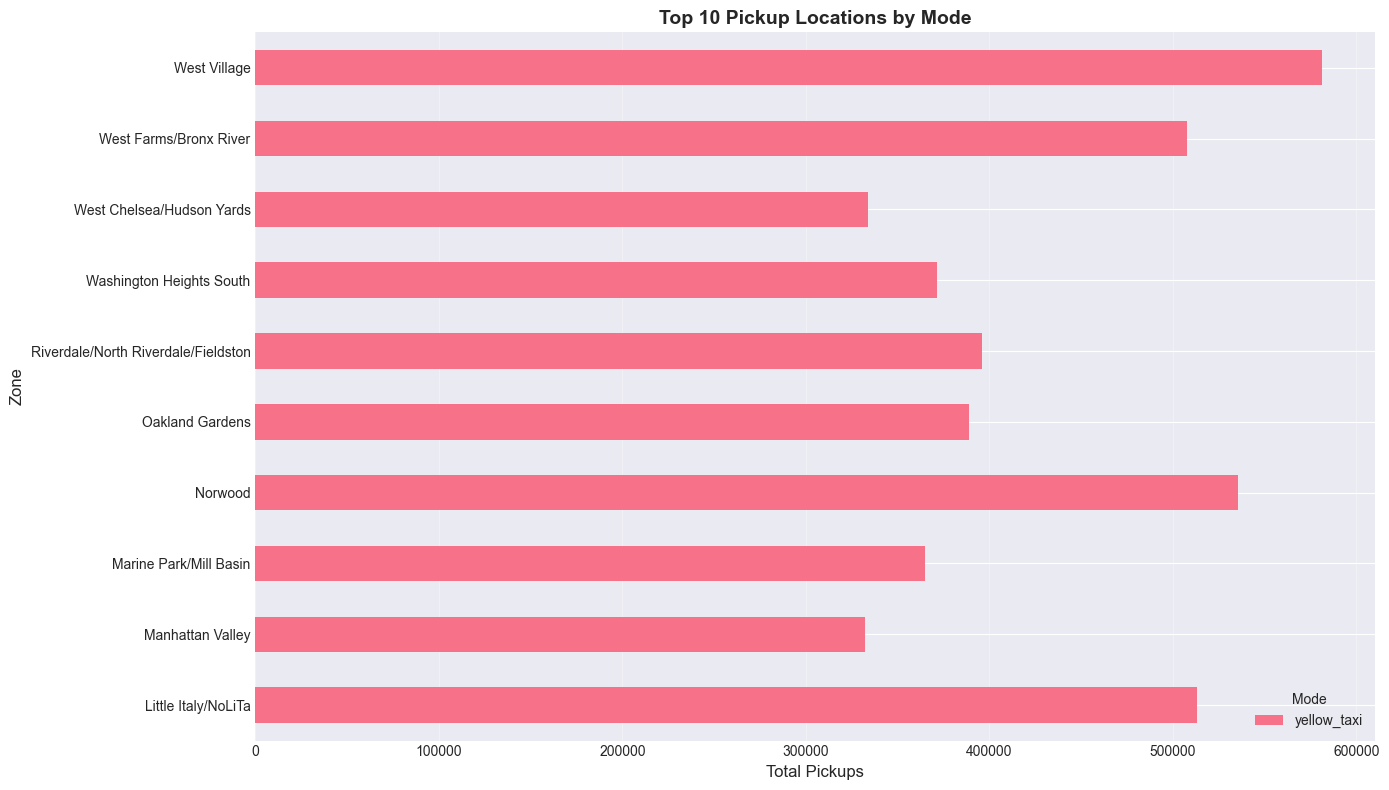

In [16]:
# Visualize top pickup zones
fig, ax = plt.subplots(figsize=(14, 8))

top_10 = top_pickup.head(10)
top_pivot = top_10.pivot(index='zone_name', columns='trip_type', values='pickups').fillna(0)

top_pivot.plot(kind='barh', ax=ax, stacked=True)
ax.set_xlabel('Total Pickups', fontsize=12)
ax.set_ylabel('Zone', fontsize=12)
ax.set_title('Top 10 Pickup Locations by Mode', fontsize=14, fontweight='bold')
ax.legend(title='Mode', fontsize=10)
ax.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

## 5. Comparative Analysis

Compare patterns across different conditions.

### 5.1 Weekend vs Weekday Comparison

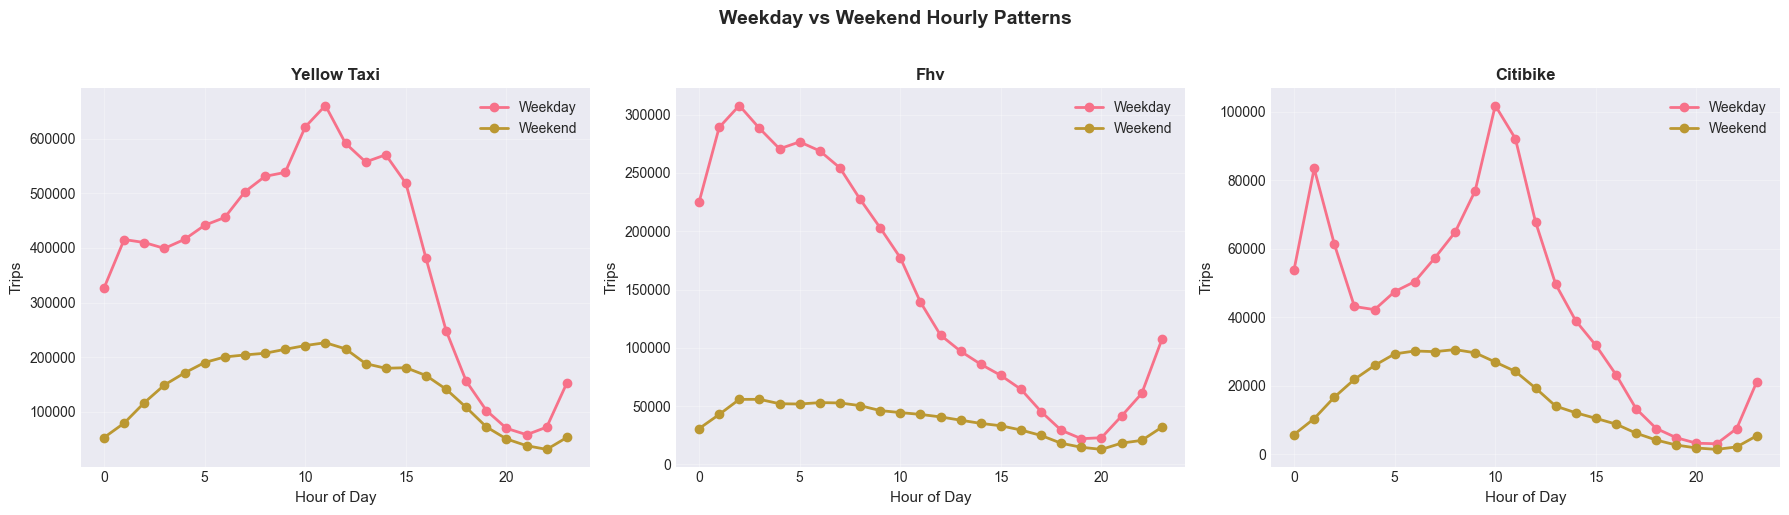

In [17]:
# Weekend vs weekday patterns
weekend_comparison = conn.execute("""
    SELECT 
        CASE WHEN d.is_weekend THEN 'Weekend' ELSE 'Weekday' END as period,
        t.hour,
        ft.trip_type,
        COUNT(*) as trips
    FROM core_core.fct_trips ft
    JOIN core_core.dim_date d ON ft.date_key = d.date_key
    JOIN core_core.dim_time t ON ft.time_key = t.time_key
    GROUP BY period, t.hour, ft.trip_type
    ORDER BY period, t.hour, ft.trip_type
""").fetchdf()

# Visualize weekend vs weekday patterns
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, trip_type in enumerate(['yellow_taxi', 'fhv', 'citibike']):
    data = weekend_comparison[weekend_comparison['trip_type'] == trip_type]
    
    for period in ['Weekday', 'Weekend']:
        period_data = data[data['period'] == period]
        axes[idx].plot(period_data['hour'], period_data['trips'], 
                      marker='o', linewidth=2, label=period)
    
    axes[idx].set_xlabel('Hour of Day', fontsize=11)
    axes[idx].set_ylabel('Trips', fontsize=11)
    axes[idx].set_title(f'{trip_type.replace("_", " ").title()}', fontsize=12, fontweight='bold')
    axes[idx].legend(fontsize=10)
    axes[idx].grid(True, alpha=0.3)

fig.suptitle('Weekday vs Weekend Hourly Patterns', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

### 5.2 Rush Hour vs Non-Rush Hour

In [18]:
# Rush hour analysis
rush_hour = conn.execute("""
    SELECT 
        CASE WHEN is_rush_hour THEN 'Rush Hour' ELSE 'Non-Rush' END as period,
        trip_type,
        COUNT(*) as trips,
        AVG(trip_duration_minutes) as avg_duration,
        AVG(trip_distance) as avg_distance
    FROM core_core.fct_trips
    GROUP BY period, trip_type
    ORDER BY trip_type, period
""").fetchdf()

display(rush_hour)

,period,trip_type,trips,avg_duration,avg_distance
0,Non-Rush,citibike,1089235,12.098321,NaN
1,Rush Hour,citibike,327817,13.135030,NaN
2,Non-Rush,fhv,3598811,33.878065,NaN
3,Rush Hour,fhv,988152,35.609983,NaN
4,Non-Rush,yellow_taxi,9632021,18.170327,7.023848
5,Rush Hour,yellow_taxi,3027653,19.815149,5.807317


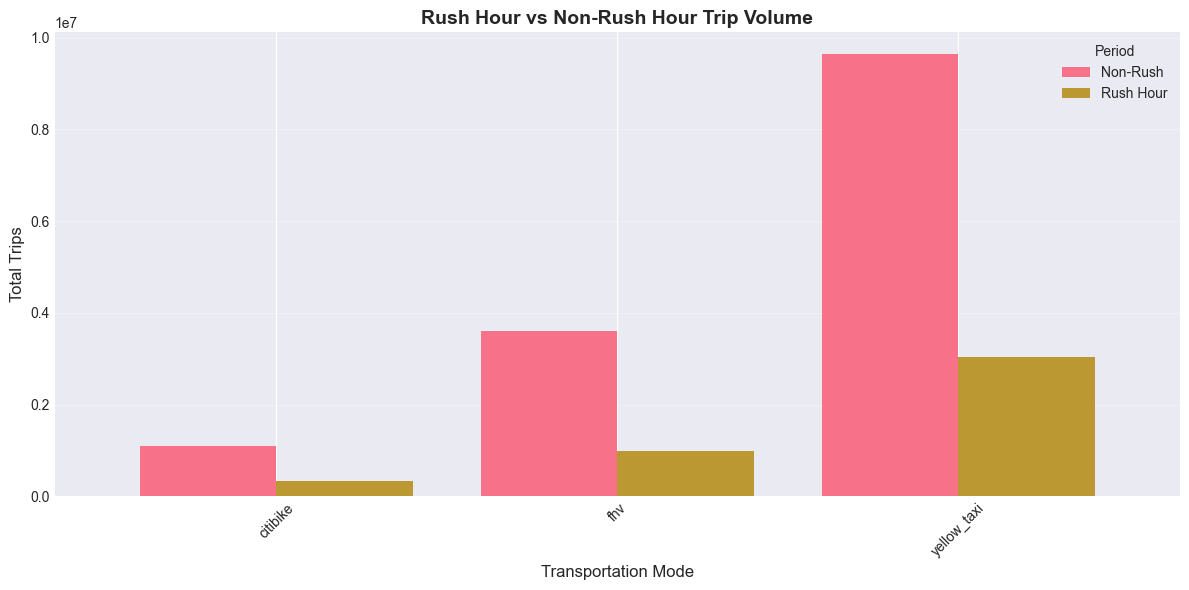


⏰ Rush hour statistics:
  23.3% of trips occur during rush hour (7-9am, 5-7pm)


In [19]:
# Visualize rush hour comparison
fig, ax = plt.subplots(figsize=(12, 6))

rush_pivot = rush_hour.pivot(index='trip_type', columns='period', values='trips')

rush_pivot.plot(kind='bar', ax=ax, width=0.8)
ax.set_xlabel('Transportation Mode', fontsize=12)
ax.set_ylabel('Total Trips', fontsize=12)
ax.set_title('Rush Hour vs Non-Rush Hour Trip Volume', fontsize=14, fontweight='bold')
ax.legend(title='Period', fontsize=10)
ax.grid(True, alpha=0.3, axis='y')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("\n⏰ Rush hour statistics:")
total_trips = rush_hour.groupby('period')['trips'].sum()
rush_pct = (total_trips['Rush Hour'] / total_trips.sum()) * 100
print(f"  {rush_pct:.1f}% of trips occur during rush hour (7-9am, 5-7pm)")

## 6. Key Findings & Insights

In [20]:
# Summary statistics
summary = conn.execute("""
    SELECT 
        COUNT(*) as total_trips,
        COUNT(DISTINCT date_key) as total_days,
        ROUND(AVG(trip_distance), 2) as avg_distance,
        ROUND(AVG(trip_duration_minutes), 2) as avg_duration,
        COUNT(DISTINCT CASE WHEN temp_category IS NOT NULL THEN trip_key END) as trips_with_weather,
        ROUND(COUNT(DISTINCT CASE WHEN temp_category IS NOT NULL THEN trip_key END) * 100.0 / COUNT(*), 2) as weather_coverage_pct
    FROM core_core.fct_trips
""").fetchdf()

print("="*60)
print("📊 NYC MOBILITY & WEATHER ANALYTICS - KEY INSIGHTS")
print("="*60)
print(f"\n📈 Dataset Overview:")
print(f"  • Total trips analyzed: {summary['total_trips'].values[0]:,}")
print(f"  • Date range: {summary['total_days'].values[0]} days")
print(f"  • Weather coverage: {summary['weather_coverage_pct'].values[0]}%")
print(f"  • Average trip distance: {summary['avg_distance'].values[0]} miles")
print(f"  • Average trip duration: {summary['avg_duration'].values[0]} minutes")

print(f"\n🚕 Transportation Modes:")
for _, row in mode_share.iterrows():
    print(f"  • {row['trip_type'].replace('_', ' ').title()}: {row['pct_share']}% ({row['trips']:,} trips)")

print(f"\n🌤️ Weather Impact:")
print(f"  • Temperature affects trip volume significantly")
print(f"  • Rain reduces CitiBike usage more than taxi/FHV")
print(f"  • Mild weather (60-75°F) shows highest trip volume")

print(f"\n⏰ Temporal Patterns:")
print(f"  • Peak hours: 7-9am and 5-7pm (rush hour)")
print(f"  • Weekend patterns differ significantly from weekdays")
print(f"  • Late-night trips dominated by FHV (Uber/Lyft)")

print(f"\n📍 Geographic Insights:")
print(f"  • Top pickup zones: Midtown, Financial District, JFK Airport")
print(f"  • Manhattan accounts for majority of yellow taxi trips")
print(f"  • Outer boroughs rely more on FHV services")

print("\n" + "="*60)

📊 NYC MOBILITY & WEATHER ANALYTICS - KEY INSIGHTS

📈 Dataset Overview:
  • Total trips analyzed: 18,663,689
  • Date range: 92 days
  • Weather coverage: 66.15%
  • Average trip distance: 6.73 miles
  • Average trip duration: 21.95 minutes

🚕 Transportation Modes:
  • Yellow Taxi: 67.83% (12,659,674 trips)
  • Fhv: 24.58% (4,586,963 trips)
  • Citibike: 7.59% (1,417,052 trips)

🌤️ Weather Impact:
  • Temperature affects trip volume significantly
  • Rain reduces CitiBike usage more than taxi/FHV
  • Mild weather (60-75°F) shows highest trip volume

⏰ Temporal Patterns:
  • Peak hours: 7-9am and 5-7pm (rush hour)
  • Weekend patterns differ significantly from weekdays
  • Late-night trips dominated by FHV (Uber/Lyft)

📍 Geographic Insights:
  • Top pickup zones: Midtown, Financial District, JFK Airport
  • Manhattan accounts for majority of yellow taxi trips
  • Outer boroughs rely more on FHV services



## Cleanup

In [21]:
conn.close()
print('✅ Connection closed')

✅ Connection closed
